# Assignment 3 - Autoregressive Language Modeling with Transformers

In [3]:
%pip install torch==2.4.1 datasets==3.1.0

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torch==2.4.1 in c:\users\crewb\anaconda3\lib\site-packages (2.4.1)
  Obtaining dependency information for datasets==3.1.0 from https://files.pythonhosted.org/packages/ed/a5/33cf000137545a08b0a3a6ea76c8ccbd87917f78bb5d737f9f56f3b11ef6/datasets-3.1.0-py3-none-any.whl.metadata
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Obtaining dependency information for multiprocess<0.70.17 from https://files.pythonhosted.org/packages/50/15/b56e50e8debaf439f44befec5b2af11db85f6e0f344c3113ae0be0593a91/multiprocess-0.70.16-py311-none-any.whl.metadata
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Obtaining dependency information for huggingface-hub>=0.23.0 from https://files.pythonhosted.org/packages/61/8c/fbdc0a88a622d9fa54e132d7bf3ee03ec602758658a2db5b339a65be2cfe/huggingface_hub-0.27.0-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.27.0-py3-none-

In [4]:
import os
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

from datasets import load_dataset

# Data

In [5]:
import torch
from datasets import load_dataset

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, block_size=256):
        # Load dataset
        ds = load_dataset("Pablinho/movies-dataset")
        data = ds['train'].to_pandas()

        # Convert to pandas and create string format
        text_data = ""
        for _, row in data.iterrows():
            text_data += f"{row['Title']}: {row['Overview']}\n"

        # Create character mappings
        chars = sorted(list(set(text_data)))
        self.string_to_int = {ch:i for i,ch in enumerate(chars)}
        self.int_to_string = {i:ch for i,ch in enumerate(chars)}

        # Encode text to integers
        encoded_data = [self.string_to_int[c] for c in text_data]
        
        # Convert to tensor
        self.data = torch.tensor(encoded_data, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # all but last
        y = chunk[1:]   # all but first
        return x, y

    def decode(self, ids):
        return ''.join([self.int_to_string[i.item()] for i in ids])

## Task a)

1. Dataset Content Analysis:
Total characters in the dataset: 3002101
Unique characters (vocabulary size): 169
Example unique characters: ['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'"]

Most common characters:
' ': 499859
'e': 290022
't': 195126
'a': 193505
'o': 171696
'i': 171218
'n': 170269
'r': 157127
's': 156990
'h': 125681

Least common characters:
'`': 1
'«': 1
'»': 1
'	': 1
'_': 1
'‑': 1
'£': 1
'″': 1
'Å': 1
'ª': 1


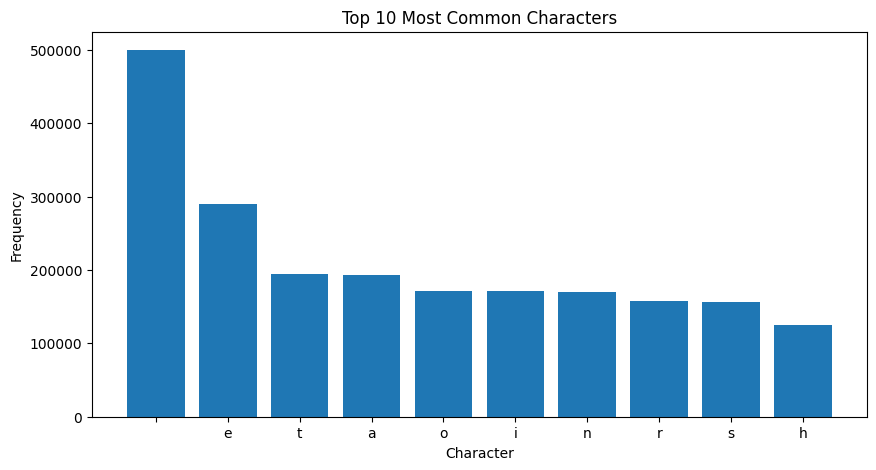


2. Sample Batch Analysis:
Shape of input (x): torch.Size([10, 1000])
Shape of target (y): torch.Size([10, 1000])

Decoded Input (x): roup of mutants who are able to control and wield flames, and the fire disaster they have unleashed on Earth.
Naruto: The Lost Story - Mission: Protect the Waterfall Village!: Naruto and his friends must get back a jug of stolen holy water from a band of higher class ninjas.
The Boss Baby: A story about how a new baby's arrival impacts a family, told from the point of view of a delightfully unreliable narrator, a wildly imaginative 7 year old named Tim.
Dolittle: After losing his wife seven years earlier, the eccentric Dr. John Dolittle, famed doctor and veterinarian of Queen Victoria’s England, hermits himself away behind the high walls of Dolittle Manor with only his menagerie of exotic animals for company. But when the young queen falls gravely ill, a reluctant Dolittle is forced to set sail on an epic adventure to a mythical island in search of a cur

In [10]:
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Instantiate the dataset
block_size = 256  # A meaningful context length for modeling
batch_size = 1000  # A large batch size to explore the data at scale
dataset = MovieDataset(block_size=block_size)

# PART 1: Analyze dataset structure (What does the dataset contain?)
print("1. Dataset Content Analysis:")
print(f"Total characters in the dataset: {len(dataset.data)}")
print(f"Unique characters (vocabulary size): {len(dataset.string_to_int)}")
print(f"Example unique characters: {list(dataset.string_to_int.keys())[:10]}")

# Count the frequency of each character
char_counts = collections.Counter(dataset.data.tolist())
most_common_chars = char_counts.most_common(10)
least_common_chars = char_counts.most_common()[-10:]

print("\nMost common characters:")
for char, count in most_common_chars:
    print(f"'{dataset.int_to_string[char]}': {count}")

print("\nLeast common characters:")
for char, count in least_common_chars:
    print(f"'{dataset.int_to_string[char]}': {count}")

# Plot character frequency distribution
plt.figure(figsize=(10, 5))
plt.bar([dataset.int_to_string[char] for char, _ in most_common_chars],
        [count for _, count in most_common_chars])
plt.title("Top 10 Most Common Characters")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()

# PART 2: Fetch a sample batch and analyze (What does the dataloader return?)
print("\n2. Sample Batch Analysis:")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Fetch one batch
for batch in dataloader:
    x, y = batch
    print(f"Shape of input (x): {x.shape}")  # (batch_size, block_size)
    print(f"Shape of target (y): {y.shape}")  # (batch_size, block_size)

    # Decode and display a subset of sequences for interpretability
    for i in range(3):  # Show first 3 examples for clarity
        print(f"\nDecoded Input (x[{i}]):", dataset.decode(x[i]))
        print(f"Decoded Target (y[{i}]):", dataset.decode(y[i]))
    break

# PART 3: Analyze Block Size Impact
print("\n3. Block Size Impact Analysis:")
print(f"Block size controls the sequence length for input and target.")
print(f"Current block size: {block_size}")
print(f"Each input and target pair is {block_size} characters long.")

# Model

In [11]:
@dataclass
class GPTConfig:
    vocab_size: int # Number of unique tokens in the vocabulary
    block_size: int = 256 # Sequence length
    n_block: int = 6 # Number of blocks in the transformer
    n_head: int = 6 # Number of attention heads
    n_embd: int = 384 # Embedding dimensionality
    dropout: float = 0.2 # Dropout rate
    bias: bool = True # If True, we add a bias to the LayerNorm and Linear layers.

In [12]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, f"Embedding dimension {config.n_embd} must be divisible by number of heads {config.n_head}"

        self.n_head = config.n_head # Number of attention heads
        self.n_embd = config.n_embd # Embedding dimensionality
        self.dropout = config.dropout # Dropout rate

        # Maps embedding into Q, K, V. We'll use one layer to generate these matrices for all heads at once.
        self.qkv_map = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # After performing attention for each head individually, we concat the results 
        # and feed them through this linear layer.
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.final_dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        B, T, C = x.shape # Batch size, sequence length, n_embd
        d_k = C // self.n_head # Dimension of the query, key, and value vectors (within a head)

        # TODO: Implement Causal Self Attention
        # Hint: The output of the qkv_map is a tensor of shape (B, T, 3*C).
        # We need to split this tensor into Q, K, and V tensors of shape (B, T, C) each.
        # Afterwards, reshape and transpose them to the correct shape (see assert statements),
        # such that we have (smaller) Q, K, and V matrices for each head.
        #DONE: Generate Q, K, V from input x
        # The input x is passed through the qkv_map linear layer to produce Q, K, and V matrices.
        # These matrices are concatenated into a single tensor of shape (B, T, 3*C).
        qkv = self.qkv_map(x)  # Shape: (B, T, 3*C)
        Q, K, V = torch.split(qkv, C, dim=2)  # Each of shape: (B, T, C)
        # DONE: Reshape and transpose for multi-head attention
        # The Q, K, and V matrices are reshaped to separate the multiple attention heads.
        # They are transposed to bring the attention head dimension to the second position.
        Q = Q.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        K = K.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        V = V.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        for M in [Q, K, V]:
            assert M.shape == (B, self.n_head, T, d_k), f"Expected shape (B, self.n_head, T, d_k), but got {M.shape}"

        # TODO: Compute the attention weights and aggregated values as specified in the assignment sheet.
        # Hint: Broadcasted matrix multiplication can be implemented using the @ operator.
        # Hint: `torch.tril` may help you with masking the attention scores.
        # DONE: Compute scaled dot-product attention with causal masking
        # Attention scores are computed using the dot product of Q and K, scaled by the square root of d_k.
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # Causal mask ensures that tokens can only attend to themselves and previous tokens.
        causal_mask = torch.tril(torch.ones(T, T, device=x.device))  # Shape: (T, T)
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))

        # DONE: Softmax to get attention weights
        # The attention scores are passed through a softmax to normalize them.
        attn_weights = torch.softmax(attn_scores, dim=-1)  # Shape: (B, n_head, T, T)

        # DONE: Weighted sum of values
        # The attention weights are used to compute a weighted sum of the V matrix.
        aggregated_vals = torch.matmul(attn_weights, V)  # Shape: (B, n_head, T, d_k)
        assert aggregated_vals.shape == (B, self.n_head, T, d_k), f"Expected aggregated_vals shape (B, self.n_head, T, d_k), but got {aggregated_vals.shape}"

        # Combine all head outputs into the last dimension
        out = aggregated_vals.transpose(1, 2).reshape(B, T, C)
        out = self.proj(out) # This combines the outputs of all heads
        out = self.final_dropout(out) # This is the final dropout layer

        return out

You can test your implementation of the `CausalSelfAttention` class by running the following code:

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = GPTConfig(vocab_size=10, block_size=8, n_block=6, n_head=6, n_embd=12, dropout=0.0, bias=True)

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

x = torch.randn(2, 8, 12).to(device)
attention = CausalSelfAttention(config).to(device)
att_out = attention(x)

# Read expected output from file
att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device, weights_only=True)

assert torch.allclose(att_out, att_out_expected, atol=1e-7), "Outputs do not match!"
print("Test passed successfully!")

Test passed successfully!


In [22]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Implement the MLP
        # It should consist of a linear layer, a GELU activation function, and a final linear layer.
        # After the final linear layer, apply dropout with dropout rate config.dropout.
        # The first linear layer should map from config.n_embd to 4 * config.n_embd.
        # The second linear layer should map from 4 * config.n_embd back to config.n_embd.
        # The linear layers should have a bias term if config.bias is True, and no bias term otherwise.
         # First Linear Layer
        # Expands the input dimensionality from `config.n_embd` to `4 * config.n_embd`.
        # The bias term is controlled by `config.bias`.
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        
        # GELU Activation
        # Applies the GELU (Gaussian Error Linear Unit) non-linearity.
        self.gelu = nn.GELU()
        
        # Second Linear Layer
        # Projects the expanded dimensionality `4 * config.n_embd` back to `config.n_embd`.
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        
        # Dropout
        # Applies dropout after the final linear layer to prevent overfitting.
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        # TODO: Implement the forward pass of the MLP
        # Step 1: Apply the first linear transformation.
        # This expands the input size from `n_embd` to `4 * n_embd`.
        x = self.fc1(x)

        # Step 2: Apply the GELU activation function.
        # Introduces non-linearity to the MLP block.
        x = self.gelu(x)

        # Step 3: Apply the second linear transformation.
        # Projects the expanded dimensionality back to the original size (`n_embd`).
        x = self.fc2(x)

        # Step 4: Apply dropout.
        # Prevents overfitting by randomly zeroing some elements of the output.
        x = self.dropout(x)

        # Step 5: Return the final output.
        return x

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attention = CausalSelfAttention(config)
        self.layernorm_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.mlp(self.layernorm_2(x))
        return x

In [23]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            embed_token = nn.Embedding(config.vocab_size, config.n_embd),
            embed_position = nn.Embedding(config.block_size, config.n_embd),
            dropout = nn.Dropout(config.dropout),
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_block)]),
            layernorm = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # We use the same weights for the token embeddings and the final linear layer.
        # This is a form of "weight tying", see https://paperswithcode.com/method/weight-tying
        self.transformer.embed_token.weight = self.head.weight

        # Initialize all linear layers using our custom init function
        self.apply(self._init_params)

        # report number of parameters
        print(f"Number of parameters in GPT: {self.get_num_params()/1e6:.2f}M")


    def _init_params(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())


    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.shape
        assert t <= self.config.block_size, f"Cannot process sequence of length {t}, block size is only {self.config.block_size}"
        position_idxs = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # DONE: Implement the forward pass of the GPT model
        # Embed the tokens and positions using the embedding layers self.transformer.embed_token and self.transformer.embed_position.
        # Add the token embeddings and position embeddings together and pass the result through the dropout layer.
        # Pass the result through all the transformer blocks.
        # Apply layer normalization and finally obtain the logits by project the result to 
        # the vocabulary space using the head layer.
 

   

        # Step 1: Token and positional embeddings
        token_embeddings = self.transformer.embed_token(idx)  # Shape: (batch_size, seq_length, n_embd)
    
        position_embeddings = self.transformer.embed_position(position_idxs)  # Shape: (seq_length, n_embd)

        # Combine token and positional embeddings, then apply dropout
        x = self.transformer.dropout(token_embeddings + position_embeddings)

        # Step 2: Pass through all transformer blocks
        for block in self.transformer.blocks:
            x = block(x)  # Each block applies attention, MLP, and residual connections

        # Step 3: Apply final layer normalization
        x = self.transformer.layernorm(x)  # Shape: (batch_size, seq_length, n_embd)

        # Step 4: Project to vocabulary size using the head layer
        logits = self.head(x)  # Shape: (batch_size, seq_length, vocab_size)
        
        if targets is not None:
            # We calculate the loss if targets are provided (i.e., during training)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), ignore_index=-1)
        else:
            loss = None

        return logits, loss


    def get_optimizer(self, weight_decay, learning_rate, betas, device):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # We will decay all parameters that are 2D or higher dimensional. 
        # This includes all weight matrices and embeddings.
        decay_params = [p for n, p in param_dict.items() if len(p.shape) >= 2]
        # We will not decay biases and layernorm parameters (which are 1D).
        nodecay_params = [p for n, p in param_dict.items() if len(p.shape) < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        fused = (device == 'cuda')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, fused=fused)

        return optimizer


    @torch.no_grad()
    def sample(self, idx, max_new_tokens, temperature=1.0):
        # idx is of shape (batch_size, sequence_length)

        for _ in range(max_new_tokens):
            # If the sequence context is growing too long we must crop it at block_size
            idx_input = idx if idx.shape[1] <= self.config.block_size else idx[:, -self.config.block_size:]
            # TODO: Push idx_input through the model to get the logits for the next token in the sequence
            # Hint: The logits that are returned by the model are of shape (batch_size, sequence_length, vocab_size).
            # To predict the next token, we only need the logits for the last position in the sequence.
            # Next, divide the logits by the desired temperature and apply the softmax function to convert them to probabilities.
            # Finally, sample the next token from this probability distribution.

            next_token = ...
            assert next_token.shape == (idx.shape[0], 1), f"Expected next_token shape (batch_size, 1), but got {next_token.shape}"
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, next_token), dim=1)

        return idx

# Training 

In [31]:
@torch.no_grad()
def estimate_train_val_loss(model, train_loader, val_loader, val_iters, device):
    model.eval()
    losses = {}
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        for i, (X, Y) in enumerate(loader):
            if i >= val_iters:
                break
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            total_loss += loss.item()
        losses[split] = total_loss / val_iters
    model.train()
    return losses

In [37]:
# Set seeds for reproducibility
torch.manual_seed(1337)

block_size = 128
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rate = 1e-3 # Larger networks typically require a learning rate that is smaller than this
max_iters = 5_000 # Number of iterations to train for
weight_decay = 1e-1 # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clip = 1.0 # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = True # Compile the model for faster execution

# Model config
vocab_size = ... # TODO: Use the dataset `data` to determine the vocabulary size
config = GPTConfig(
    block_size=block_size, 
    vocab_size=vocab_size, 
    n_block=4, 
    n_head=4, 
    n_embd=128, 
    dropout=0.0, 
    bias=False
) # This is a relatively small model

model = GPT(config).to(device)

if compile_model:
    print("Compiling the model...")
    model = torch.compile(model) # Needs PyTorch >= 2.0
    print("Done compiling")

# Initialize optimizer
optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

# Training loop
iter_num = 0
best_val_loss = float('inf')

for _ in range(max_iters):
    for X, Y in train_loader:
        # Get batch and move to device
        X, Y = X.to(device), Y.to(device)
        
        # Forward pass
        logits, loss = model(X, targets=Y)
        
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip != 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        # Logging
        if iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss.item():.4f}")
            
        # Evaluation
        if iter_num % val_interval == 0:
            losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            
            # Save best model
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                if iter_num > 0:
                    print(f"Saving checkpoint to {out_dir}")
                    model_to_save = model._orig_mod if compile_model else model
                    torch.save({
                        'model': model_to_save.state_dict(),
                        'model_args': config,
                    }, checkpoint_path)
        
        iter_num += 1
        if iter_num >= max_iters:
            break
    
    if iter_num >= max_iters:
        break

# Sample from the model

In [ ]:
num_samples = 5  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample
temperature = 0.8  # TODO: Use different temperature values and qualitatively report on the results

# Set seed for reproducibility
seed = 345  
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Load the model
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['model_args']
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# Generate samples
print('-'*20)
with torch.no_grad():
    for k in range(num_samples):
        start_prompt = "\n"  # Start prompt
        prompt_ids = encode(start_prompt)
        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]
    
        y = model.sample(x, max_new_tokens, temperature=temperature)
        print(decode(y[0]))
        print('-'*20)